In [1]:
import os
import glob

basedir = '../vehicles/'

image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir + imtype + '/*'))
    
print("Number of car images: ", len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn + '\n')
        
        
basedir = '../non-vehicles/'

image_types = os.listdir(basedir)
not_cars = []
for imtype in image_types:
    not_cars.extend(glob.glob(basedir + imtype + '/*'))
    
print("Number of non-car images: ", len(not_cars))
with open("not_cars.txt", 'w') as f:
    for fn in not_cars:
        f.write(fn + '\n')

Number of car images:  8792
Number of non-car images:  8968


In [16]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
from functions import *

In [7]:
color_space = 'YCrCb'
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()

car_features = extract_features(cars, color_space = color_space, spatial_size = spatial_size, 
                               hist_bins = hist_bins, orient = orient, pix_per_cell = pix_per_cell,
                               cell_per_block = cell_per_block, hog_channel = hog_channel, 
                               spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)

notcar_features = extract_features(not_cars, color_space = color_space, spatial_size = spatial_size, 
                               hist_bins = hist_bins, orient = orient, pix_per_cell = pix_per_cell,
                               cell_per_block = cell_per_block, hog_channel = hog_channel, 
                               spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)

print(time.time() - t, 'seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.1, random_state = rand_state)

print("Feature vector length: ", len(X_train[0]))
svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
print(round(time.time() - t, 2), "seconds to train SVC")
print("Test accuracy of SVC = ", round(svc.score(X_test, y_test), 4))

/home/rohan/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


237.75215339660645 seconds to compute features...
Feature vector length:  7872
31.31 seconds to train SVC
Test accuracy of SVC =  0.9944


In [46]:
import pickle

pickle.dump(svc, open("pickle/svc_9944.p", "wb"))
pickle.dump(X_scaler, open("pickle/scaler_allimages.p", "wb"))

In [17]:
def visualize(fig, rows, cols, imgs, titles):
    
    for i,img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)
        plt.title(i + 1)
        img_dims = len(img.shape)
        if img_dims < 3:
#             print("Image dimensions: ", img_dims)
            plt.imshow(img, cmap = 'hot')
            plt.title(titles[i])
        else:
#             print("Image dimensions: ", img_dims)
            plt.imshow(img)
            plt.title(titles[i])

/home/rohan/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.0421340465545654 seconds to process one frame searching 143 windows
0.8240344524383545 seconds to process one frame searching 143 windows
0.7750823497772217 seconds to process one frame searching 143 windows
0.7880303859710693 seconds to process one frame searching 143 windows
0.7763793468475342 seconds to process one frame searching 143 windows
0.7851808071136475 seconds to process one frame searching 143 windows


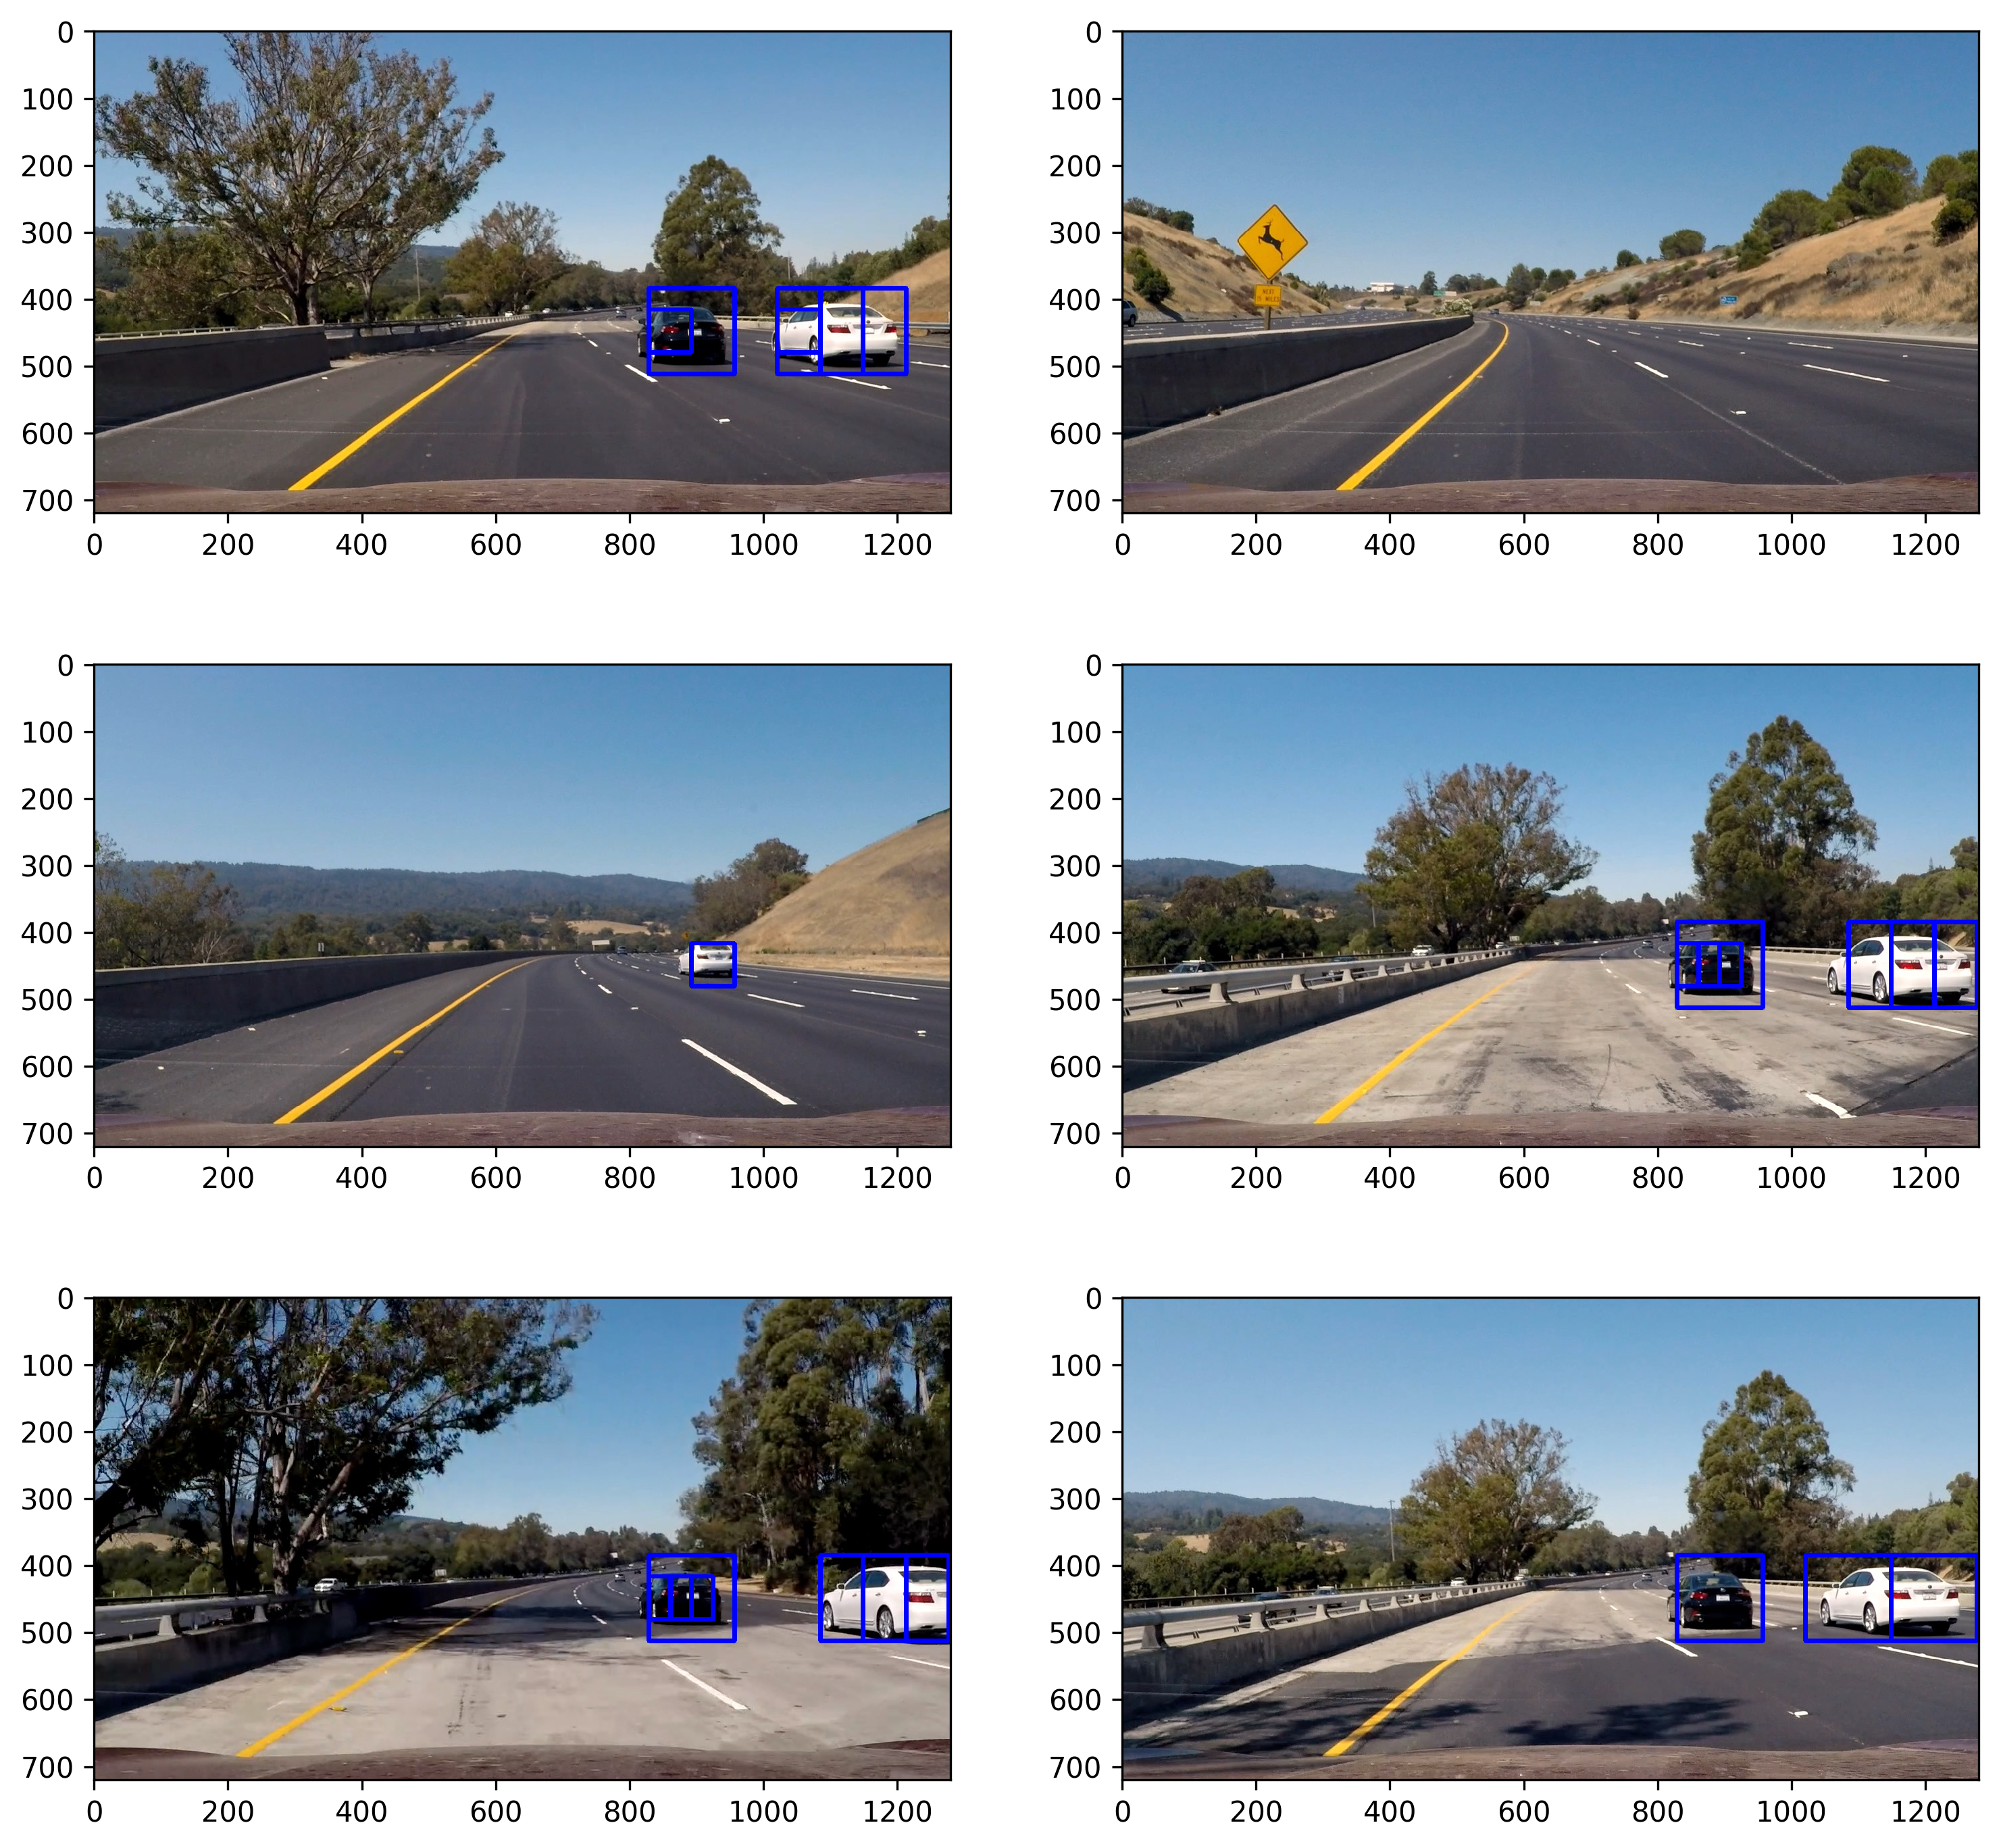

In [20]:
searchpath = '../test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [320, 600]
x_start_stop = [700, 1280]
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
#     print(np.min(img), np.max(img))
    
    windows1 = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, xy_window = (128, 128), xy_overlap = (overlap, overlap))
    windows2 = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, xy_window = (64, 64), xy_overlap = (overlap, overlap))
    windows = windows1 + windows2
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space = color_space,
                                spatial_size = spatial_size, hist_bins = hist_bins, orient = orient,
                                pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,
                                hog_channel = hog_channel, spatial_feat = spatial_feat, hist_feat = hist_feat,
                                hog_feat = hog_feat)
    
    window_img = draw_boxes(draw_img, hot_windows, color = (0, 0, 255), thick = 6)
    images.append(window_img)
    titles.append('')
    print(time.time() - t1, 'seconds to process one frame searching', len(windows), 'windows')
    
fig = plt.figure(figsize = (12, 20), dpi = 300)
visualize(fig, 5, 2, images, titles)

In [22]:
from scipy.ndimage.measurements import label

In [23]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [37]:
def find_cars(img):
    
    draw_img = np.copy(img)
    coldmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    windows1 = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, xy_window = (128, 128), xy_overlap = (overlap, overlap))
    windows2 = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, xy_window = (64, 64), xy_overlap = (overlap, overlap))
    windows = windows1 + windows2
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space = color_space,
                                spatial_size = spatial_size, hist_bins = hist_bins, orient = orient,
                                pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,
                                hog_channel = hog_channel, spatial_feat = spatial_feat, hist_feat = hist_feat,
                                hog_feat = hog_feat)
    heatmap = add_heat(coldmap, hot_windows)
    thresholded_heatmap = apply_threshold(heatmap, threshold = 0)
    window_img = draw_boxes(draw_img, hot_windows, color = (0, 0, 255), thick = 6)
    
    return window_img, thresholded_heatmap

In [53]:
def process_image(img):
    
    out_img, heatmap = find_cars(img)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, labels

In [57]:
test_img = mpimg.imread('../test_images/test2.jpg')

In [58]:
cool, labels = process_image(test_img)

In [65]:
labels[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [70]:
labels[0].shape

(720, 1280)

/home/rohan/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


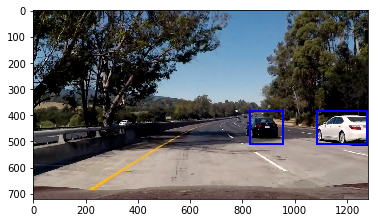

In [44]:
plt.imshow(process_image(test_img))

In [45]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'
clip = VideoFileClip('../videos/project_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [19:02<00:01,  1.03s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

